# Drive mount and imports

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
current_dir = "/gdrive/My Drive/"

%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1SsYTSWVYK18RYEggHgY0ijnOvaI-DARa/ANN-1stChallenge


In [ ]:
# Set seed for reproducibility
SEED = 42

# Import libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

f1_average = 'macro'

PyTorch version: 2.8.0+cu126
Device: cpu


# Data Loading

In [ ]:
BASE_PATH = "datasets/"

TRAIN_PATH = BASE_PATH + "pirate_pain_train.csv"
TRAIN_LABELS_PATH = BASE_PATH + "pirate_pain_train_labels.csv"
TEST_PATH = BASE_PATH + "pirate_pain_test.csv"
SUBMISSION_PATH = BASE_PATH + "sample_submission.csv"

X_train = pd.read_csv(TRAIN_PATH)
y_train = pd.read_csv(TRAIN_LABELS_PATH)

X_test = pd.read_csv(TEST_PATH)

## Encoding features

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column in y_train
y_train['label_encoded'] = label_encoder.fit_transform(y_train['label'])

# Display the mapping of original labels to encoded numbers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

y_train = y_train.drop('label', axis=1)

Label Mapping:
{'high_pain': np.int64(0), 'low_pain': np.int64(1), 'no_pain': np.int64(2)}


In [ ]:
# Encode body parts features
from sklearn.preprocessing import LabelEncoder
categorical_features = ['n_legs', 'n_hands', 'n_eyes']

encoders = {}

for col in categorical_features:
    encoders[col] = LabelEncoder()

    X_train[col + '_encoded'] = encoders[col].fit_transform(X_train[col])
    X_test[col + '_encoded'] = encoders[col].transform(X_test[col])

    print(f"Label mapping for {col}: {dict(zip(encoders[col].classes_, encoders[col].transform(encoders[col].classes_)))}")

X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)


Label mapping for n_legs: {'one+peg_leg': np.int64(0), 'two': np.int64(1)}
Label mapping for n_hands: {'one+hook_hand': np.int64(0), 'two': np.int64(1)}
Label mapping for n_eyes: {'one+eye_patch': np.int64(0), 'two': np.int64(1)}


# Train prep

In [ ]:
# Merge X_train and y_train based on 'sample_index'
df = pd.merge(X_train, y_train, on='sample_index')

# Define the columns to drop

#joint_columns_to_drop = [f'joint_{i:02d}' for i in range(13, 26)]
#joint_columns_to_drop.append('joint_30')
pain_survey_columns_to_drop = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
#body_part_columns = ['n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded']

columns_to_drop = pain_survey_columns_to_drop

# Drop the columns
df = df.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)


## Downsampling

Removing the sample indexes having the 5 highest values for each joint from 13 to 25

In [ ]:
# Analyzing only joints from 13 to 25
joint_names_to_check = [f'joint_{i:02d}' for i in range(13, 26)]

# Initialize an empty dictionary to store the results
top_samples_by_joint = {}

# Loop through each joint name
for joint_name in joint_names_to_check:
    # Get the 'sample_index' of the 5 rows with the largest values for the current joint
    top_5_rows = df.nlargest(5, joint_name)
    sample_index_list = top_5_rows['sample_index'].tolist()
    # Store the list in the dictionary with the joint name as the key
    top_samples_by_joint[joint_name] = sample_index_list

# Print results
for joint, samples in top_samples_by_joint.items():
    print(f"Top 5 Sample Indexes for {joint}")
    print(samples)
    print("\n")

--- Top 50 Sample Indexes for joint_13 ---
[44, 280, 44, 92, 44]


--- Top 50 Sample Indexes for joint_14 ---
[123, 123, 465, 92, 280]


--- Top 50 Sample Indexes for joint_15 ---
[44, 44, 559, 44, 44]


--- Top 50 Sample Indexes for joint_16 ---
[44, 44, 44, 44, 44]


--- Top 50 Sample Indexes for joint_17 ---
[381, 381, 559, 381, 44]


--- Top 50 Sample Indexes for joint_18 ---
[518, 123, 123, 123, 123]


--- Top 50 Sample Indexes for joint_19 ---
[193, 511, 11, 11, 264]


--- Top 50 Sample Indexes for joint_20 ---
[472, 300, 22, 16, 511]


--- Top 50 Sample Indexes for joint_21 ---
[465, 88, 88, 465, 444]


--- Top 50 Sample Indexes for joint_22 ---
[88, 465, 465, 338, 577]


--- Top 50 Sample Indexes for joint_23 ---
[88, 88, 193, 11, 214]


--- Top 50 Sample Indexes for joint_24 ---
[88, 521, 465, 252, 319]


--- Top 50 Sample Indexes for joint_25 ---
[465, 465, 88, 290, 34]




In [ ]:
# Find the union of all sample indexes

# Initialize an empty set to store the unique sample indexes
union_of_outliers = set()

# Loop through each list of top sample indexes in the dictionary
for sample_list in top_samples_by_joint.values():
    # add all items from the list to the set
    union_of_outliers.update(sample_list)

outlier_samples_to_remove = list(union_of_outliers)

# Print the final list of outliers
print(f"Found {len(outlier_samples_to_remove)} unique sample(s) that appear in the top 50 for at least ONE joint from joint_13 to joint_25.")
print("List of unique outlier sample indexes to remove:")
print(outlier_samples_to_remove[:100])

Found 26 unique sample(s) that appear in the top 50 for at least ONE joint from joint_13 to joint_25.
List of unique outlier sample indexes to remove:
[518, 264, 521, 11, 16, 22, 280, 290, 34, 44, 300, 559, 444, 319, 193, 577, 465, 338, 214, 472, 88, 92, 123, 252, 381, 511]


In [ ]:
df_cleaned = df[~df['sample_index'].isin(outlier_samples_to_remove)]

print("\nVerifying Removal")
print(f"Original DataFrame size: {len(df)}")
print(f"Unique outliers identified: {len(outlier_samples_to_remove)}")
print(f"Cleaned DataFrame size:   {len(df_cleaned)}")
print(f"Number of rows removed:   {len(df) - len(df_cleaned)}")


--- Verifying Removal ---
Original DataFrame size: 105760
Unique outliers identified: 26
Cleaned DataFrame size:   101600
Number of rows removed:   4160


In [ ]:
df=df_cleaned

## Feature correlation

Analyzing the following features:
Index(['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05',
       'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11',
       'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17',
       'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23',
       'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29',
       'joint_30', 'n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded',
       'label_encoded'],
      dtype='object')


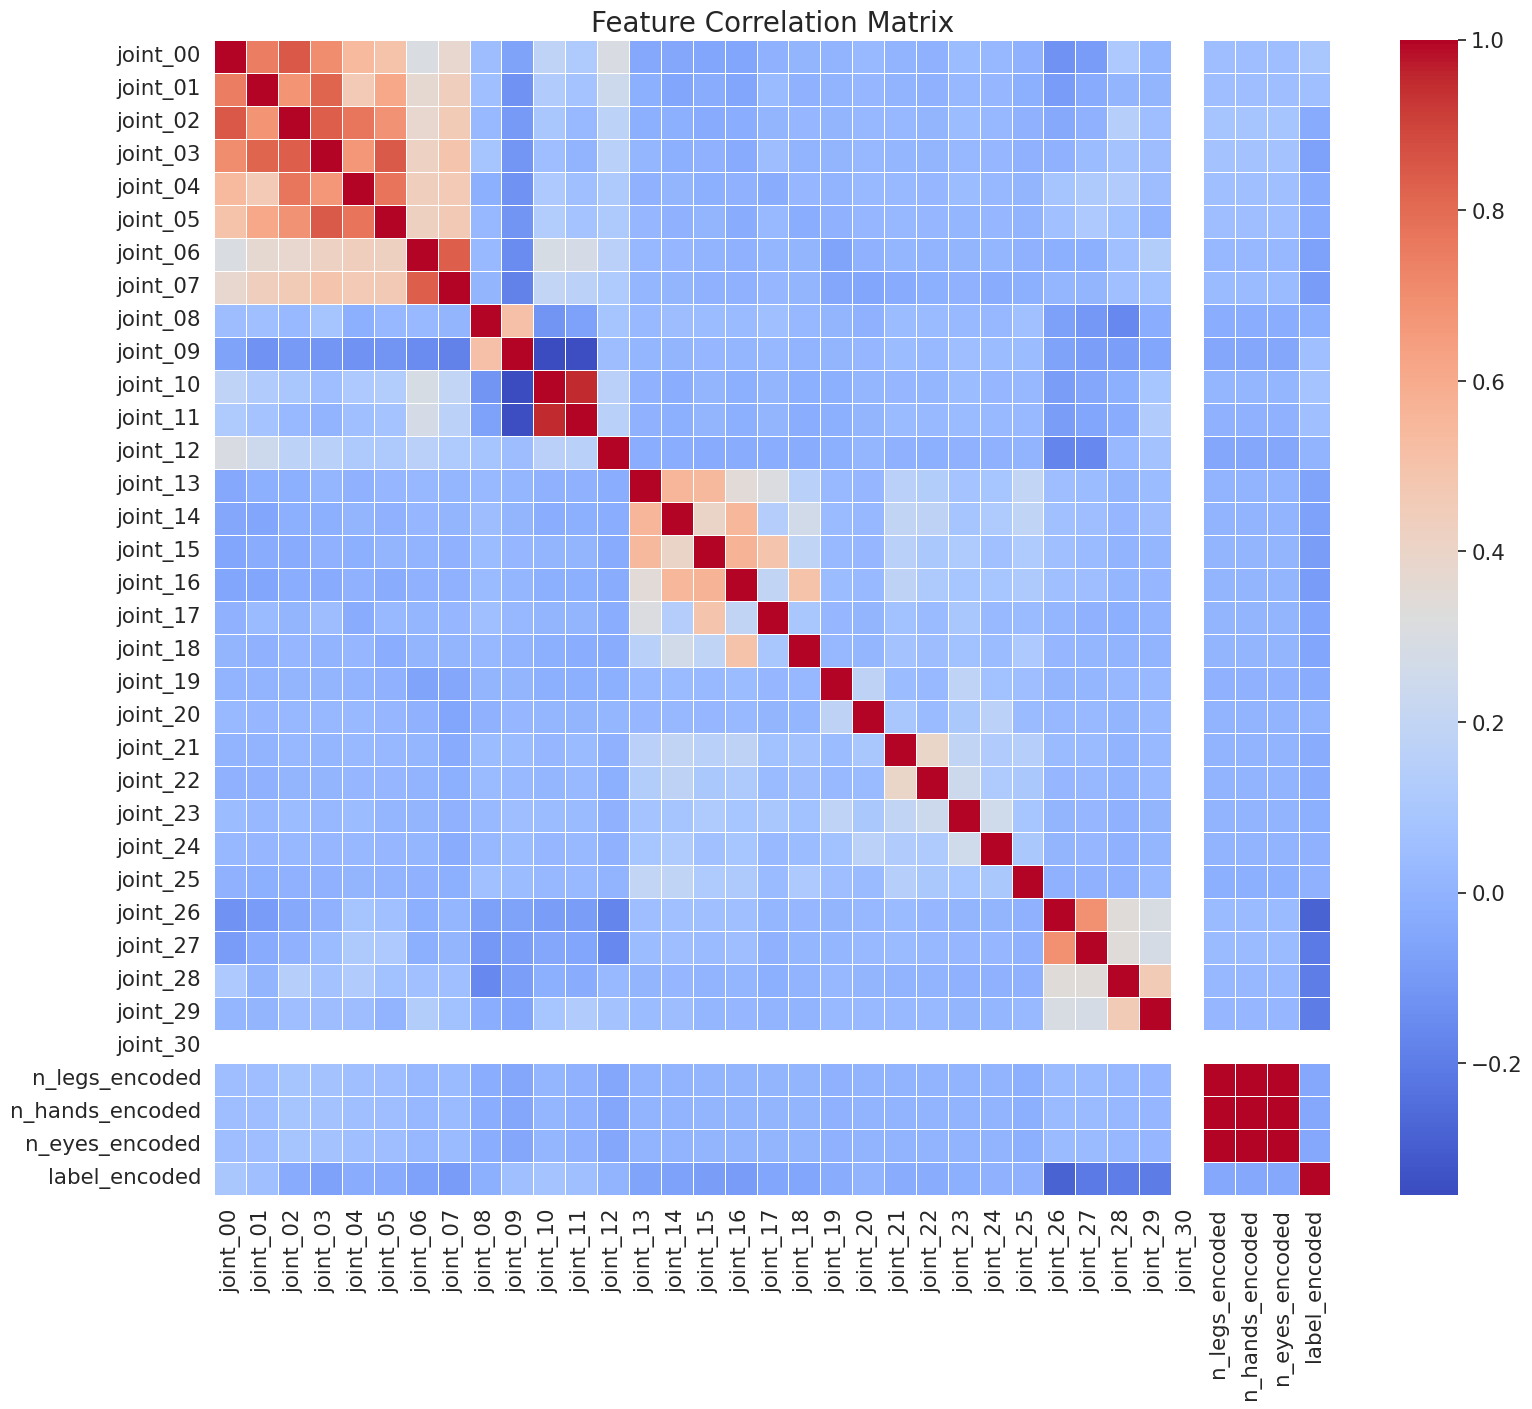

In [ ]:
features_df = df.drop(columns=['sample_index', 'time'])
print("Analyzing the following features:")
print(features_df.columns)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 15))

# Draw the heatmap
sns.heatmap(correlation_matrix,
            annot=False,
            cmap='coolwarm',
            linewidths=.5)

plt.title('Feature Correlation Matrix', fontsize=20)
plt.show()

In [ ]:
threshold = 0.90

# Create a boolean mask for pairs above the threshold
# We use abs() to catch both positive and negative correlations
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f"\nFound {len(to_drop)} features to remove with correlation > {threshold}:")
print(to_drop)

# Drop these columns from your original DataFrame
df = df.drop(columns=to_drop)

#print(f"\nOriginal number of columns: {df.shape[1]}")
print(f"Number of columns after removing redundant features: {df.shape[1]}")


Found 3 features to remove with correlation > 0.9:
['joint_11', 'n_hands_encoded', 'n_eyes_encoded']

Original number of columns: 34
Number of columns after removing redundant features: 34


## Validation split

In [ ]:
#VALIDATION SPLIT, 20% validation dataset
n_series = len(y_train)
VAL_SPLIT = 0.2
val_size = int(VAL_SPLIT * n_series)
train_size = n_series - val_size

sample_ids = y_train['sample_index'].unique()
random.seed(SEED)
random.shuffle(sample_ids)

train_samples = sample_ids[:train_size]
val_samples = sample_ids[train_size:]

print(f"Train samples {len(train_samples)}, validation samples {len(val_samples)}")

df_train = df[df['sample_index'].isin(train_samples)]
df_val = df[df['sample_index'].isin(val_samples)]

print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Train samples 529, validation samples 132
Training set shape: (81600, 34)
Validation set shape: (20000, 34)


## SCALING

### Minmax

In [ ]:
scale_columns = [col for col in df_train.columns if col.startswith('joint')]

mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

for c in scale_columns:
  df_train[c] = (df_train[c] - mins[c]) / (maxs[c] - mins[c])
  df_val[c] = (df_val[c] - mins[c]) / (maxs[c] - mins[c])
  X_test[c] = (X_test[c] - mins[c]) / (maxs[c] - mins[c])

  print(f"Min {c}: {mins[c]}, Max {c}: {maxs[c]}")

Min joint_00: 0.0, Max joint_00: 1.407968102920364
Min joint_01: 0.0, Max joint_01: 1.33461309026345
Min joint_02: 0.001175540071103, Max joint_02: 1.2370871942941035
Min joint_03: 0.005403208977202, Max joint_03: 1.254728584640333
Min joint_04: 0.0, Max joint_04: 1.3592041906601298
Min joint_05: 0.0, Max joint_05: 1.3877310476309013
Min joint_06: 0.0, Max joint_06: 1.4105319672746472
Min joint_07: 0.0, Max joint_07: 1.3619686012219738
Min joint_08: 0.2059824975044532, Max joint_08: 1.3572876989947114
Min joint_09: 0.1236058745542073, Max joint_09: 1.38810451581177
Min joint_10: 0.1176205741021279, Max joint_10: 1.631494436951367
Min joint_12: 0.4939390285906562, Max joint_12: 1.3967536513367282
Min joint_13: 0.0, Max joint_13: 0.0638035597623482
Min joint_14: 2.763049739186912e-07, Max joint_14: 0.0668803341160854
Min joint_15: 0.0, Max joint_15: 0.0651752777784983
Min joint_16: 0.0, Max joint_16: 0.0676551392924203
Min joint_17: 0.0, Max joint_17: 0.1796810098246442
Min joint_18: 0.0

# Build sequence and on

In [ ]:
# Define a function to build sequences from the dataset
def build_sequences(df, features, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][features].values

        # Retrieve the activity label for the current index
        label = df[df['sample_index'] == id]['label_encoded'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(features)), dtype='float64')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [ ]:
#pain_survey_columns = [col for col in df_train.columns if 'pain_survey' in col]
cols_to_drop = ['joint_11', 'joint_25', 'joint_30']
joint_related_columns = [col for col in df_train.columns if 'joint' in col and col not in cols_to_drop]
#time_column = ['time']
#body_parts_columns = ['n_legs_encoded','n_hands_encoded','n_eyes_encoded']

# Combine all desired feature lists into the final list
features = selected_joint_columns + ['n_legs_encoded']

print(f"Selecting {len(features)} features for the model.")
WINDOW_SIZE = 10
STRIDE = 5

print(f"selecting features: {features}")

train_x_seq, train_y_seq = build_sequences(df_train, features, window=WINDOW_SIZE, stride=STRIDE)
print(f"{len(train_x_seq)} train sequences of length {WINDOW_SIZE} and stride {STRIDE}")
val_x_seq, val_y_seq = build_sequences(df_val, features, window=WINDOW_SIZE, stride=STRIDE)
print(f"{len(val_x_seq)} validation sequences of length {WINDOW_SIZE} and stride {STRIDE}")

Selecting 29 features for the model.
selecting features: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'n_legs_encoded']
16830 train sequences of length 10 and stride 5
4125 validation sequences of length 10 and stride 5


In [ ]:
train_ds = TensorDataset(torch.from_numpy(train_x_seq).float(), torch.from_numpy(train_y_seq))
val_ds = TensorDataset(torch.from_numpy(val_x_seq).float(), torch.from_numpy(val_y_seq))

In [ ]:
BATCH_SIZE = 128

def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Newtwork and Training Hyperparams

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.05         # Dropout probability
L1_LAMBDA = 0.0001            # L1 penalty
L2_LAMBDA = 0.0001            # L2 penalty
#weights = torch.tensor([1.0, 1.1, 0.76], dtype=torch.float32).to(device)
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
input_shape = train_x_seq.shape[1:]

# Create model and display architecture with parameter count
model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=3,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='GRU'
    ).to(device)

# Set up TensorBoard logging and save model architecture
experiment_name = "juj_gru_all_columns_outliers_removed"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Train model and track training history
model, training_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
    )

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.6313, F1 Score=0.3688 | Val: Loss=0.6065, F1 Score=0.4667
Epoch   2/500 | Train: Loss=0.4438, F1 Score=0.5993 | Val: Loss=0.5301, F1 Score=0.6302
Epoch   3/500 | Train: Loss=0.3341, F1 Score=0.6971 | Val: Loss=0.4624, F1 Score=0.5917
Epoch   4/500 | Train: Loss=0.2850, F1 Score=0.7414 | Val: Loss=0.4419, F1 Score=0.7219
Epoch   5/500 | Train: Loss=0.2153, F1 Score=0.8147 | Val: Loss=0.4650, F1 Score=0.6961
Epoch   6/500 | Train: Loss=0.1941, F1 Score=0.8417 | Val: Loss=0.4509, F1 Score=0.7556
Epoch   7/500 | Train: Loss=0.1745, F1 Score=0.8596 | Val: Loss=0.4081, F1 Score=0.7403
Epoch   8/500 | Train: Loss=0.1525, F1 Score=0.8784 | Val: Loss=0.4111, F1 Score=0.7726
Epoch   9/500 | Train: Loss=0.1381, F1 Score=0.8936 | Val: Loss=0.4703, F1 Score=0.7564
Epoch  10/500 | Train: Loss=0.1136, F1 Score=0.9150 | Val: Loss=0.4465, F1 Score=0.7804
Epoch  11/500 | Train: Loss=0.1148, F1 Score=0.9161 | Val: Loss=0.3972, F1 Score=0.7803
Epoch  12

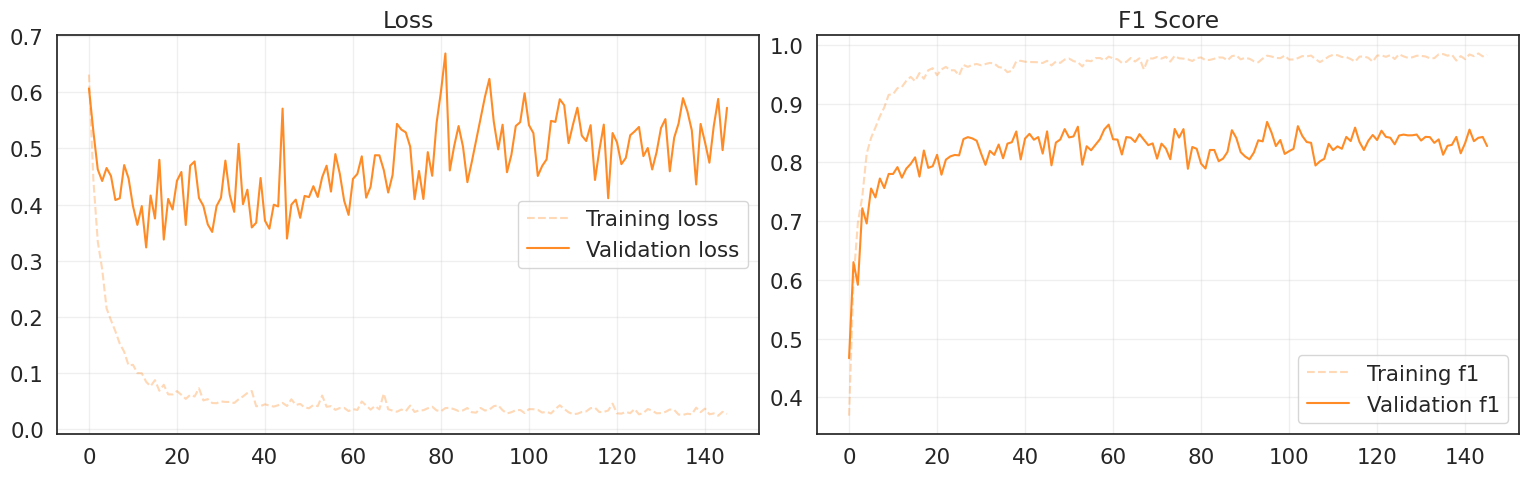

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9331
Precision over the validation set: 0.9060
Recall over the validation set: 0.8384
F1 score over the validation set: 0.8690


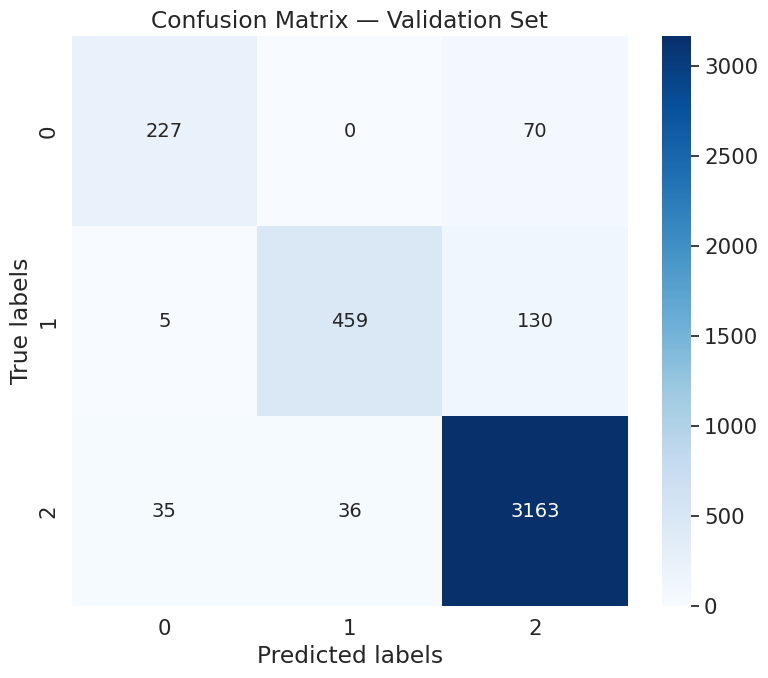

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average=f1_average)
val_rec = recall_score(val_targets, val_preds, average=f1_average)
val_f1 = f1_score(val_targets, val_preds, average=f1_average)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()